<img src="REcoM.png" alt="Drawing" style="width: 900px; margin: 0 auto">
<p style="text-align: center;">This notebook is an extensive demonstration of the *py_recom* module. *py_recom* is a tool for the evaluation of REcoM model outputs.</p>

### Table of Contents

* [0. Configuration](#CONFIG)

* [3. Carbonate systen](#CARBS)
    * [3.1 Maps](#CARBSMAPS)
         * [3.1.1 DIC](#DICMAP)
         * [3.1.2 Alkalinity](#ALKMAP)
         * [3.1.3 pCO2](#PCO2MAP)
         * [3.1.4 CO2f](#CO2FMAP)
    * [3.2 CO2 flux Time-series](#CARBSTS)
    * [3.3 Profiles](#CARBSPRO)

# 0. Configuration<a class="anchor" id="CONFIG"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import socket
import sys
import os
home = os.path.expanduser("~")
sys.path.append(home+'/py_f2recom/GlobalAssessment/')
sys.path.append(home+ '/py_f2recom/modules/')
sys.path.append(home+ '/py_f2recom/modules/pyfesom2')
sys.path.append(home+ '/py_f2recom/modules/cmocean-master/')
sys.path.append(home+'/py_f2recom/modules/SkillMetrics/')
import pyfesom2 as pf
import skill_metrics as sm
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset

Autosaving every 5 seconds
osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
#    Only modify parameters and paths in this cell       #
#  In principle, you don't have to modify anything else  #


# run specification -------------------------------------------------------------------------------------   
runid      =  'fesom'
simu_name = 'A' # only usefull if you want to save figures

# defines paths ----------------------------------------------------------------------------------------- 

if socket.gethostname()[:5] == 'blogi':
    meshpath = '/scratch/usr/hbkoziel/mesh/farc'
    resultpath = '/scratch/projects/hbk00083/model_outputs/fesom2.1_recom'+simu_name+'/'
    savepath = home+'/pyfesom2/codes/py_f2recom_develop/outputs/'+simu_name+'/'
    evalpath      = '/scratch/usr/hbkoziel/evaluation/'
    evalpath2      = '/scratch/usr/hbkoziel/corrected_input/'
elif socket.gethostname()[:5] in ['albed','prod-']:
    #resultpath = '/albedo/work/projects/p_bio/model_output/A_riv'
    resultpath = '/albedo/work/projects/MarESys/GCB2022/A'
    savepath = home+'/py_f2recom/outputs/'+simu_name+'/'
    evalpath = '/albedo/work/projects/p_pool_recom/eval/'
    meshpath = '/albedo/work/projects/p_bio/mesh/core2/'
    #meshpath = '/albedo/work/user/yye/fesom2/meshes/core2_albedo/'
else:
    print('sorry, machine unknown, please customize your paths yourself')

# period of analysis ------------------------------------------------------------------------------------
first_year_maps = 2012
first_year = 2012
last_year  = 2021
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(first_year_maps,last_year+1,1)

# specification of analysis ------------------------------------------------------------------------------------
layerwise = False
depths = (0,50,200,1000,2000) # If layerwise is True, you can define depths here, by defaut: (0,50,200,1000,2000,4000)
uplow = [0, 100]
mapproj = 'rob'
# Map projection ptions are : Mercator (merc), Plate Carree (pc),
# North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
# Robinson projection is quite time consuming.

In [3]:
# export of analysis ------------------------------------------------------------------------------------
# Be aware that exporting figures may alter (crop) the display but the printed figures are okay
# This is because of bugs in the 'constrained_layout' matplotlib experimental function 
# that may be fixed in the future matplotlib version but out of our control
# If you prefer having a nice HTML, savefig must be turned off
#--------------------------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")
savefig = True 
htmlname     =  simu_name+'_'+ today +'_carbs.html'
htmlpath = savepath
verbose = True

if not os.path.exists(htmlpath): # create folders if do not exist
    os.makedirs(htmlpath)
if not os.path.exists(savepath):
    os.makedirs(savepath)
    
# initialization file specifications -----------------------------------------------------------

ncfileAlk                = evalpath+'data/GLODAPv2.2016b.TAlk_mmol.nc'
ncfileDIC                = evalpath+'data/GLODAPv2.2016b.TCO2_mmol.nc'
ncfilepCO2               = evalpath+'SOCATv2020_tracks_gridded_monthly.nc'
ncfileCO2f               = evalpath+'dataset_CO2_Chauetal2020.nc'
txtfileCO2flux           = evalpath+'CO2_flux2015_Takahashietal2009_original.txt'

# visual check
if(verbose):
    print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
        resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))
    print('\nLast ten years are \n{0}'.format(years_last10))
    
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)
mesh.path = meshpath

# export toolbox
!jupyter nbconvert --to=python Py_f2recom_toolbox.ipynb

Processing years 2012 to 2021

Reading out of /albedo/work/projects/MarESys/GCB2022/A
Storing graphs to /albedo/home/loziel/py_f2recom/outputs/A/
Storing html to /albedo/home/loziel/py_f2recom/outputs/A/ as A__2024_02_19_carbs.html

Last ten years are 
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
/albedo/work/projects/p_bio/mesh/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /albedo/work/projects/p_bio/mesh/core2/pickle_mesh_py3_fesom2
[NbConvertApp] Converting notebook Py_f2recom_toolbox.ipynb to python
[NbConvertApp] Writing 48324 bytes to Py_f2recom_toolbox.py


# 3. Carbonate system<a class="anchor" id="BGCPRO"></a>

### 3.1 Maps<a class="anchor" id="CARBSMAPS"></a>

### 3.1.1 DIC<a class="anchor" id="DICMAP"></a>

[NbConvertApp] Converting notebook DIC_GLODAP.ipynb to python
[NbConvertApp] Writing 17153 bytes to DIC_GLODAP.py
[NbConvertApp] Converting notebook load_interp_GLODAP.ipynb to python
[NbConvertApp] Writing 7234 bytes to load_interp_GLODAP.py
***
Loading GLODAP file: /albedo/work/projects/p_pool_recom/eval/data/GLODAPv2.2016b.TCO2_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0


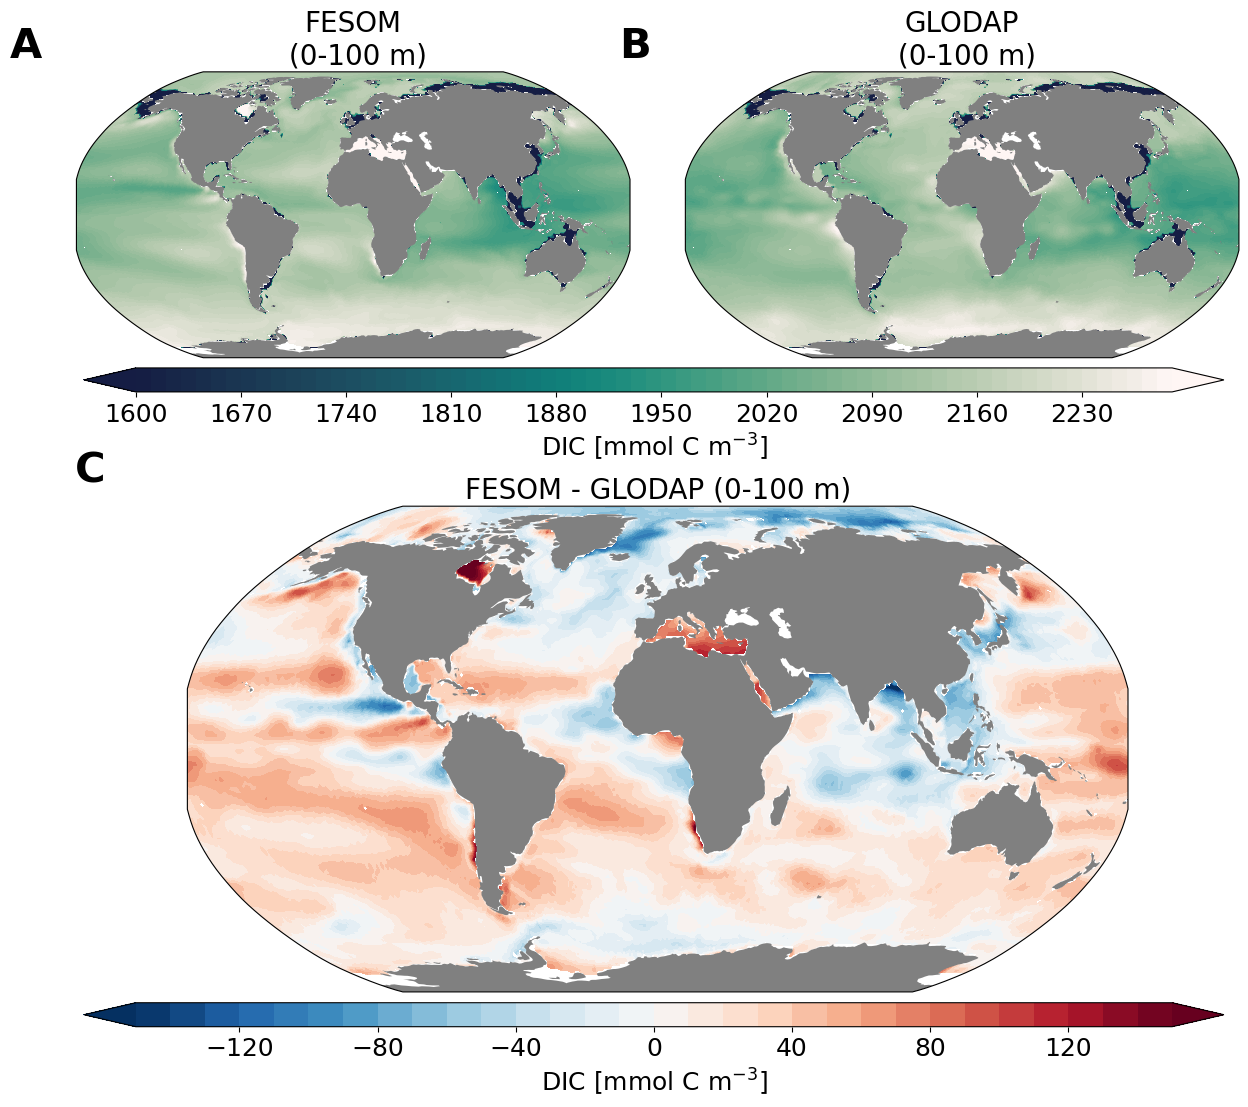


Original Taylor stats:
SDEV pred: 447.02241, ref: 444.14852
CRMS pred: 36.51258, ref: 0.00000
CORRCOEF: 0.99666

Normalized Taylor stats:
SDEV pred: 1.00647, ref: 1.00000
CRMS pred: 0.08221, ref: 0.00000
CORRCOEF: 0.99666
Adjust axis max to 1.5


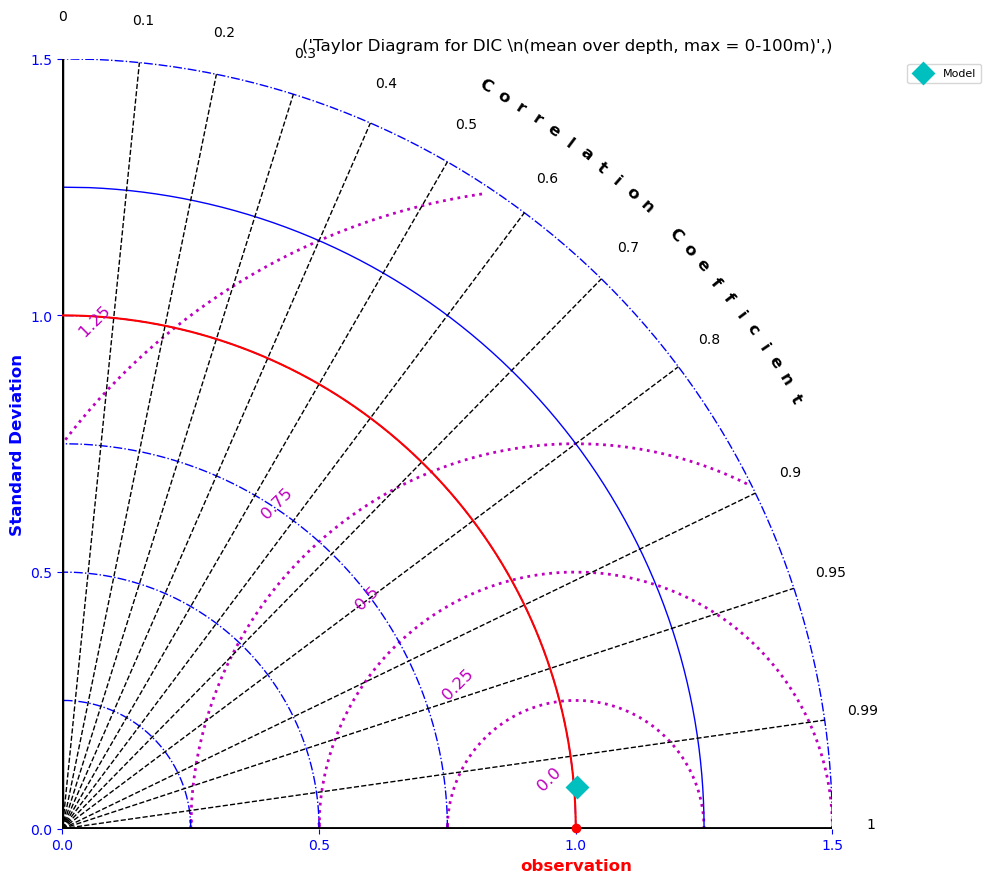

In [4]:
!jupyter nbconvert --to=python DIC_GLODAP.ipynb
!jupyter nbconvert --to=python load_interp_GLODAP.ipynb
from DIC_GLODAP import DICcomp

DICcomp(resultpath,savepath,mesh,ncfileDIC,2000,2004,mapproj=mapproj,savefig=savefig,
                 layerwise=layerwise,cmap = cmo.cm.tempo_r, cmap_extension = 'both')

### 3.1.2 Alk<a class="anchor" id="ALKMAP"></a>

[NbConvertApp] Converting notebook Alk_GLODAP.ipynb to python
[NbConvertApp] Writing 16862 bytes to Alk_GLODAP.py
[NbConvertApp] Converting notebook load_interp_GLODAP.ipynb to python
[NbConvertApp] Writing 7234 bytes to load_interp_GLODAP.py
***
Loading GLODAP file: /albedo/work/projects/p_pool_recom/eval/data/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 2166.0687, std = 499.0680, min = 503.8499, max = 2811.6004
PISCES mean = 2158.7214, std = 490.1376, min = 523.1559, max = 2698.4857


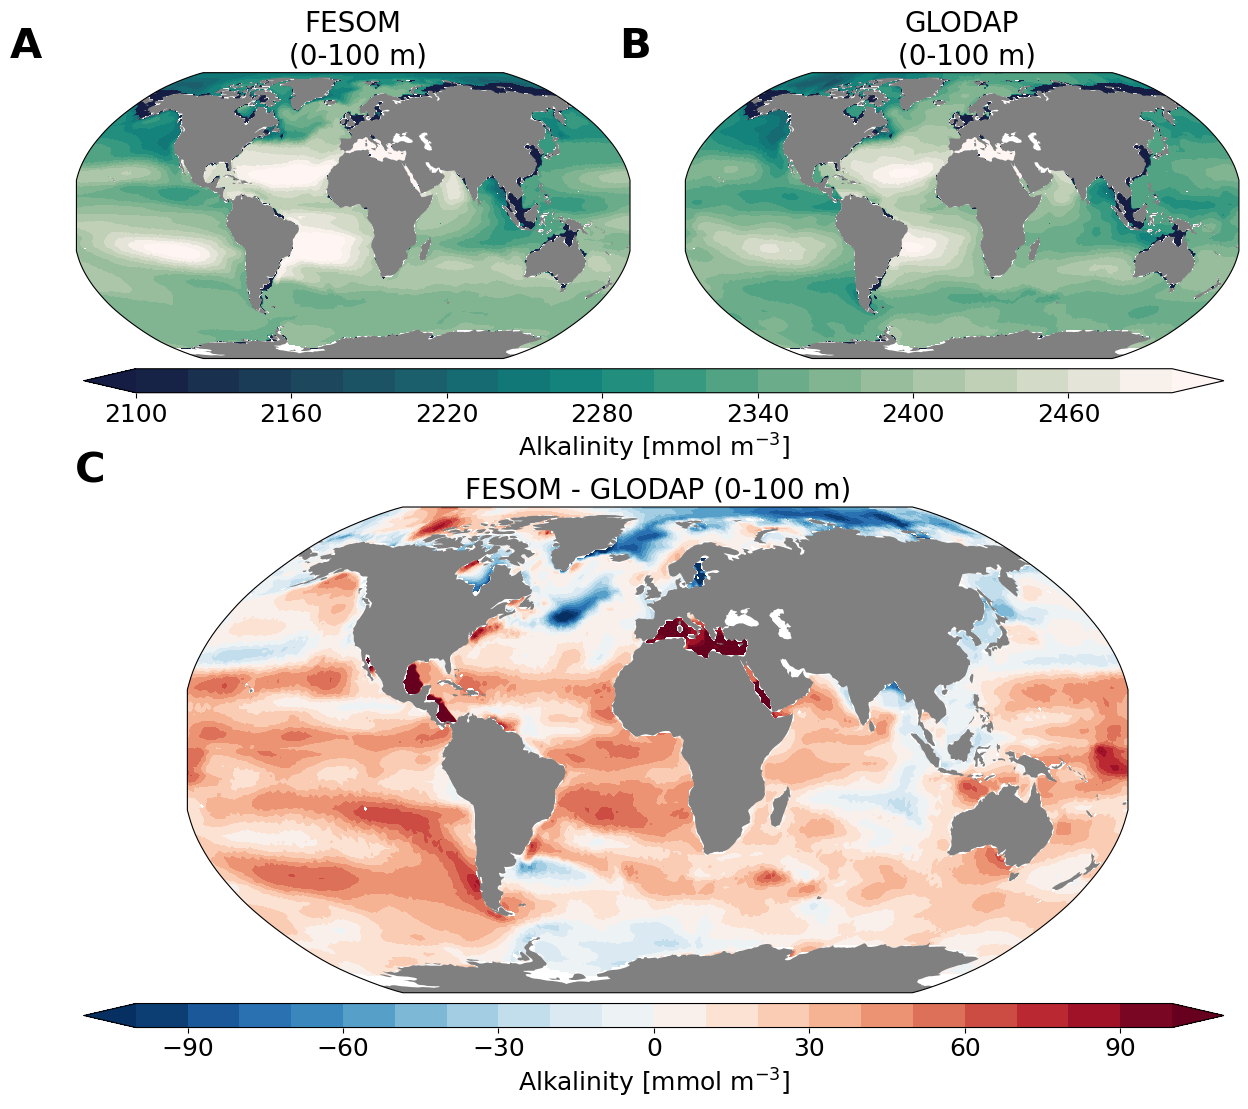


Original Taylor stats:
SDEV pred: 499.06801, ref: 490.13759
CRMS pred: 33.91990, ref: 0.00000
CORRCOEF: 0.99781

Normalized Taylor stats:
SDEV pred: 1.01822, ref: 1.00000
CRMS pred: 0.06920, ref: 0.00000
CORRCOEF: 0.99781
Adjust axis max to 1.5


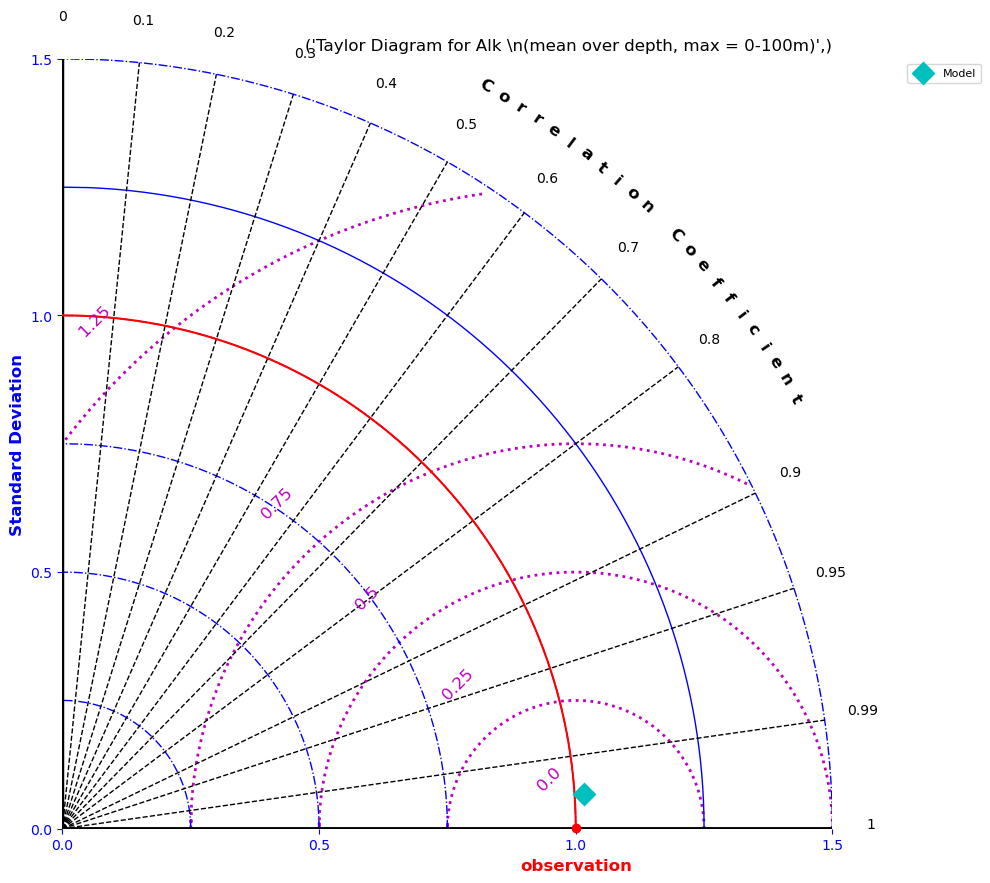

In [4]:
!jupyter nbconvert --to=python Alk_GLODAP.ipynb
!jupyter nbconvert --to=python load_interp_GLODAP.ipynb
from Alk_GLODAP import Alkcomp

Alkcomp(resultpath,savepath,mesh,ncfileAlk,2000,2004,mapproj=mapproj,savefig=savefig,
                 layerwise=layerwise, cmap = cmo.cm.tempo_r, verbose = verbose, uplow = uplow)

### 3.1.3 pCO2<a class="anchor" id="PCO2MAP"></a>

[NbConvertApp] Converting notebook pCO2_SOCAT.ipynb to python
[NbConvertApp] Writing 11374 bytes to pCO2_SOCAT.py
[NbConvertApp] Converting notebook load_interp_SOCAT.ipynb to python
[NbConvertApp] Writing 4671 bytes to load_interp_SOCAT.py
***
Loading SOCAT file: /albedo/work/projects/p_pool_recom/eval/SOCATv2020_tracks_gridded_monthly.nc
***

***
 no SOCAT data to be plotted after 2020
***

***
 years extracted in SOCCAT 2012-2020 
***
<function shape at 0x7f5c7c7552d0>


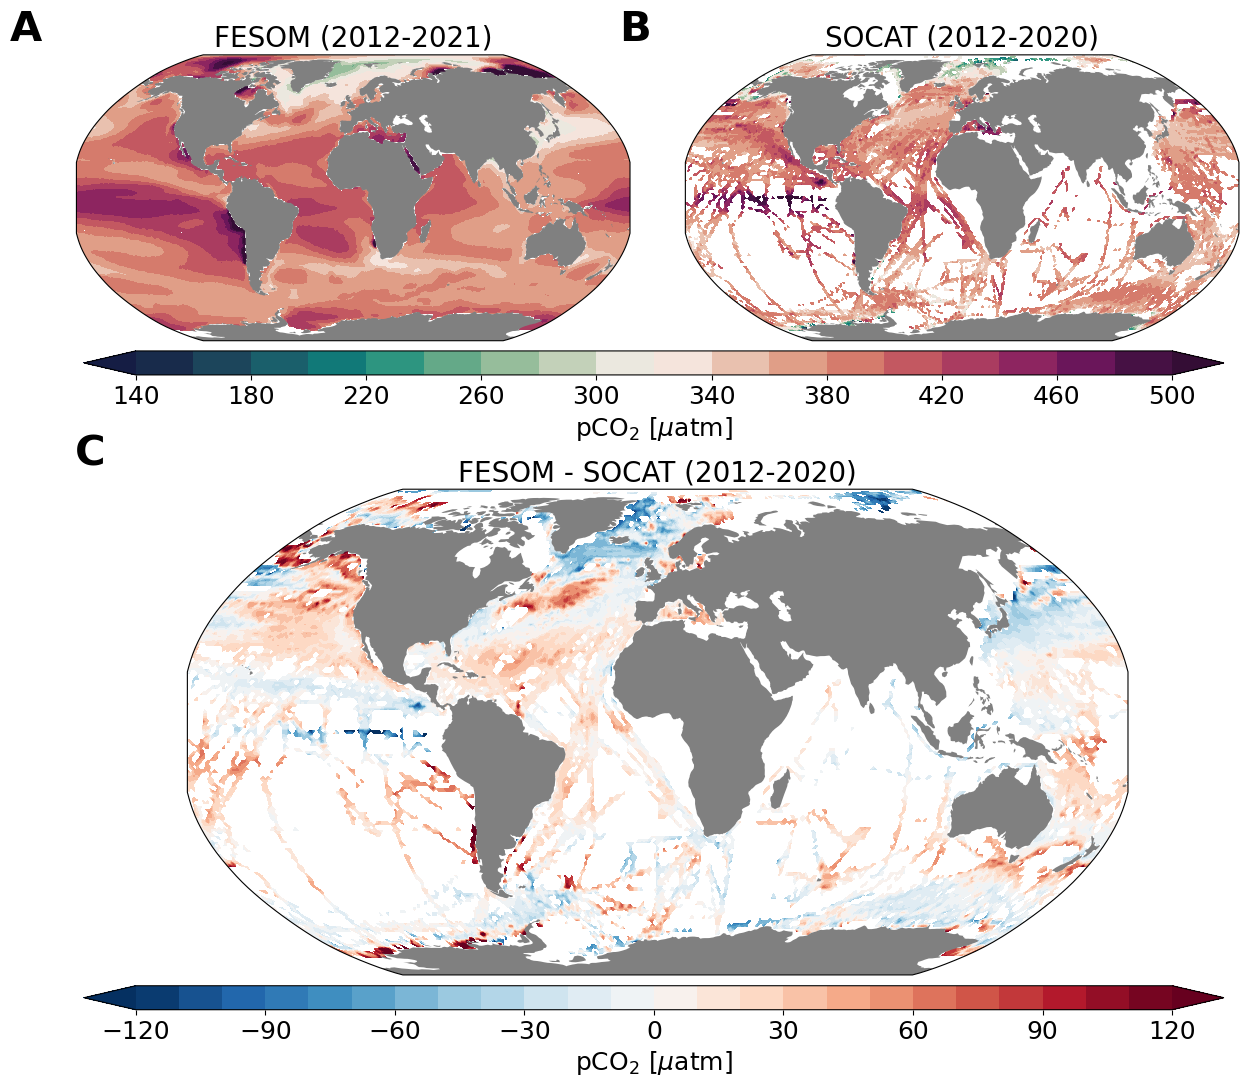


Original Taylor stats:
SDEV pred: 39.16083, ref: 50.87484
CRMS pred: 47.43585, ref: 0.00000
CORRCOEF: 0.46972

Normalized Taylor stats:
SDEV pred: 0.76975, ref: 1.00000
CRMS pred: 0.93240, ref: 0.00000
CORRCOEF: 0.46972


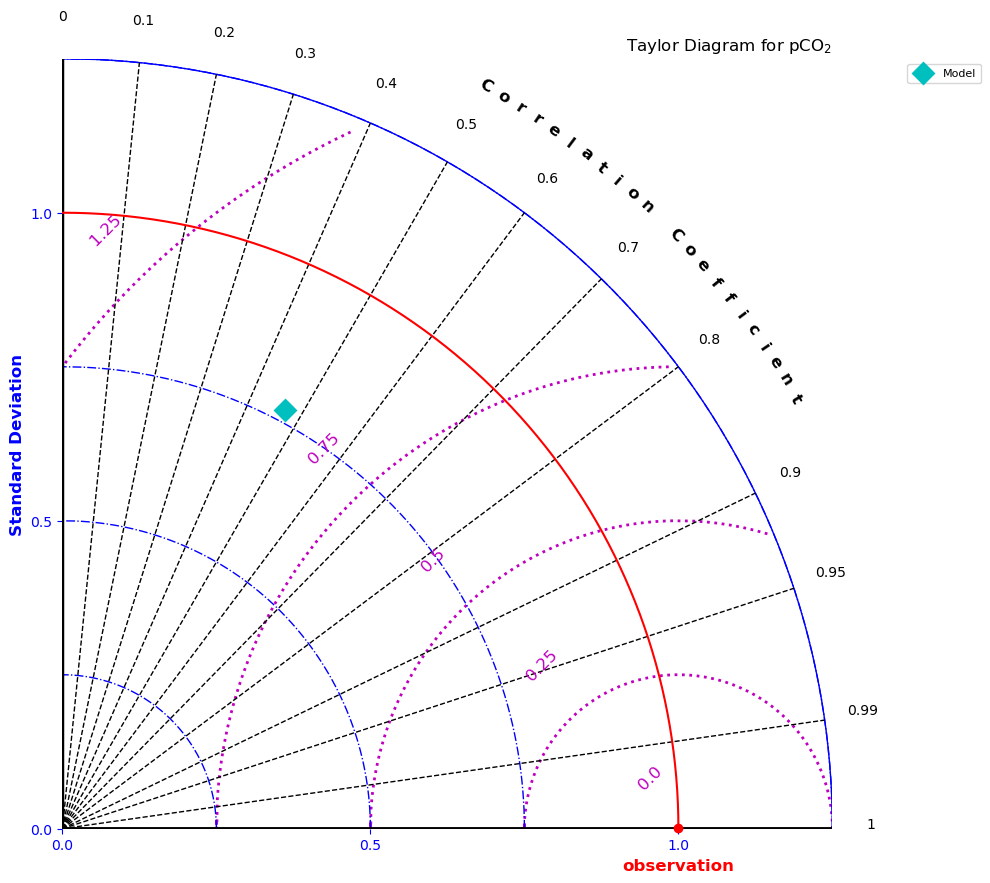

In [4]:
!jupyter nbconvert --to=python pCO2_SOCAT.ipynb
!jupyter nbconvert --to=python load_interp_SOCAT.ipynb
from pCO2_SOCAT import pCO2comp

pCO2comp(resultpath,savepath,mesh,ncfilepCO2,first_year,last_year,
                mapproj=mapproj, savefig=savefig, cmap = cmo.cm.curl)

[NbConvertApp] Converting notebook pCO2_Chauetal.ipynb to python
[NbConvertApp] Writing 13616 bytes to pCO2_Chauetal.py
[NbConvertApp] Converting notebook load_interp_Chauetal.ipynb to python
[NbConvertApp] Writing 5163 bytes to load_interp_Chauetal.py
***
Loading Chau et al. file: /albedo/work/projects/p_pool_recom/eval/dataset_CO2_Chauetal2020.nc
***

***
 years extracted in Chau et al. 2011-2019 
***
<function shape at 0x7f5c7c7552d0>


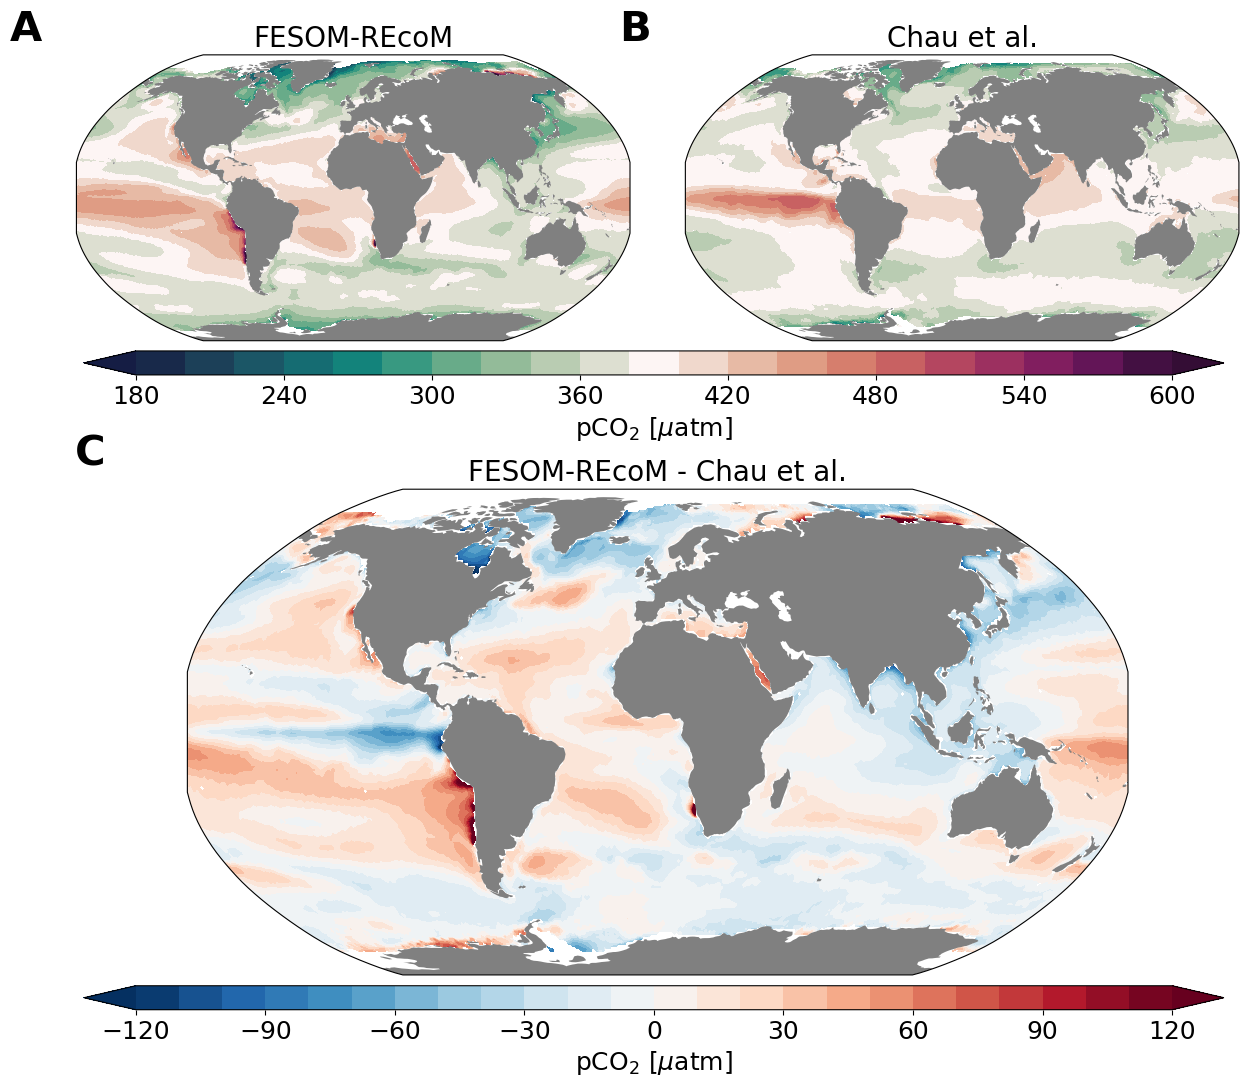


Original Taylor stats:
SDEV pred: 43.68369, ref: 34.93728
CRMS pred: 29.19853, ref: 0.00000
CORRCOEF: 0.74575

Normalized Taylor stats:
SDEV pred: 1.25035, ref: 1.00000
CRMS pred: 0.83574, ref: 0.00000
CORRCOEF: 0.74575
Adjust axis max to 1.5


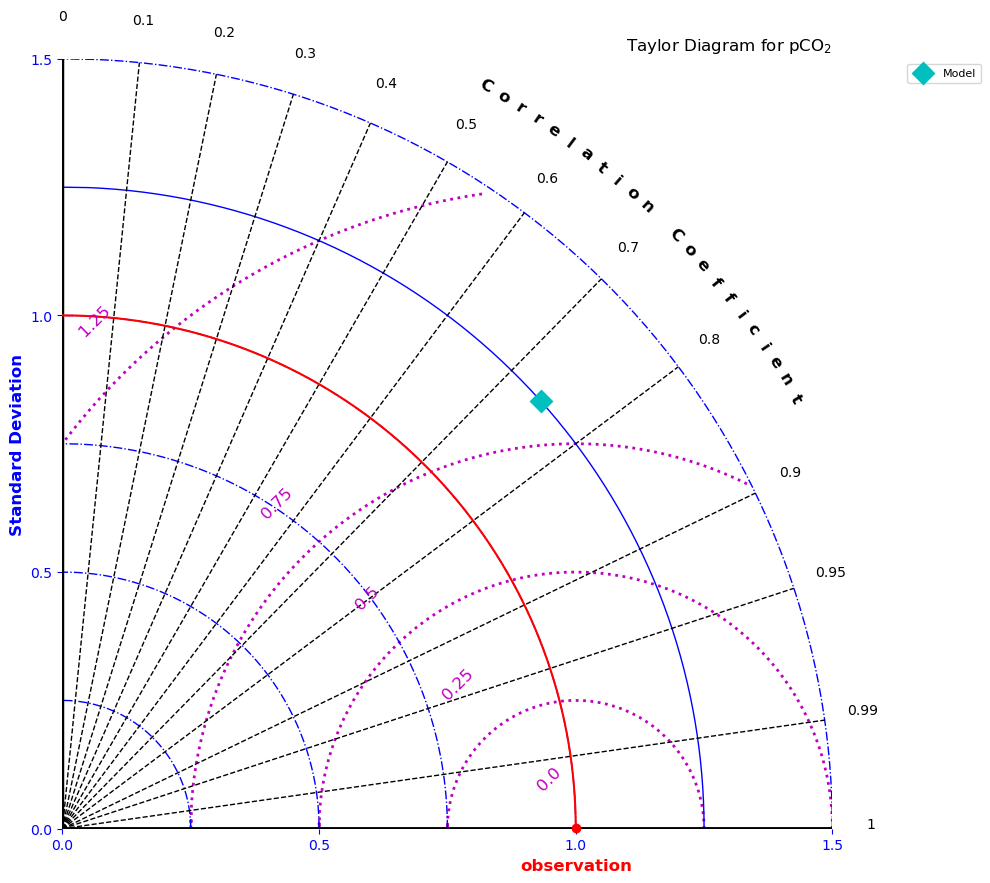

In [6]:
!jupyter nbconvert --to=python pCO2_Chauetal.ipynb
!jupyter nbconvert --to=python load_interp_Chauetal.ipynb
from pCO2_Chauetal import pCO2ccomp

pCO2ccomp(resultpath,savepath,mesh,ncfileCO2f,2011,2019,
                mapproj=mapproj, cmap = cmo.cm.curl,
                savefig=savefig, SOCATvar='spco2')

### 3.1.4 CO2f<a class="anchor" id="CO2FMAP"></a>

[NbConvertApp] Converting notebook pCO2_Chauetal.ipynb to python
[NbConvertApp] Writing 13616 bytes to pCO2_Chauetal.py
[NbConvertApp] Converting notebook load_interp_Chauetal.ipynb to python
[NbConvertApp] Writing 5163 bytes to load_interp_Chauetal.py
***
Loading Chau et al. file: /albedo/work/projects/p_pool_recom/eval/dataset_CO2_Chauetal2020.nc
***

***
 years extracted in Chau et al. 2011-2019 
***
<function shape at 0x7f5c7c7552d0>


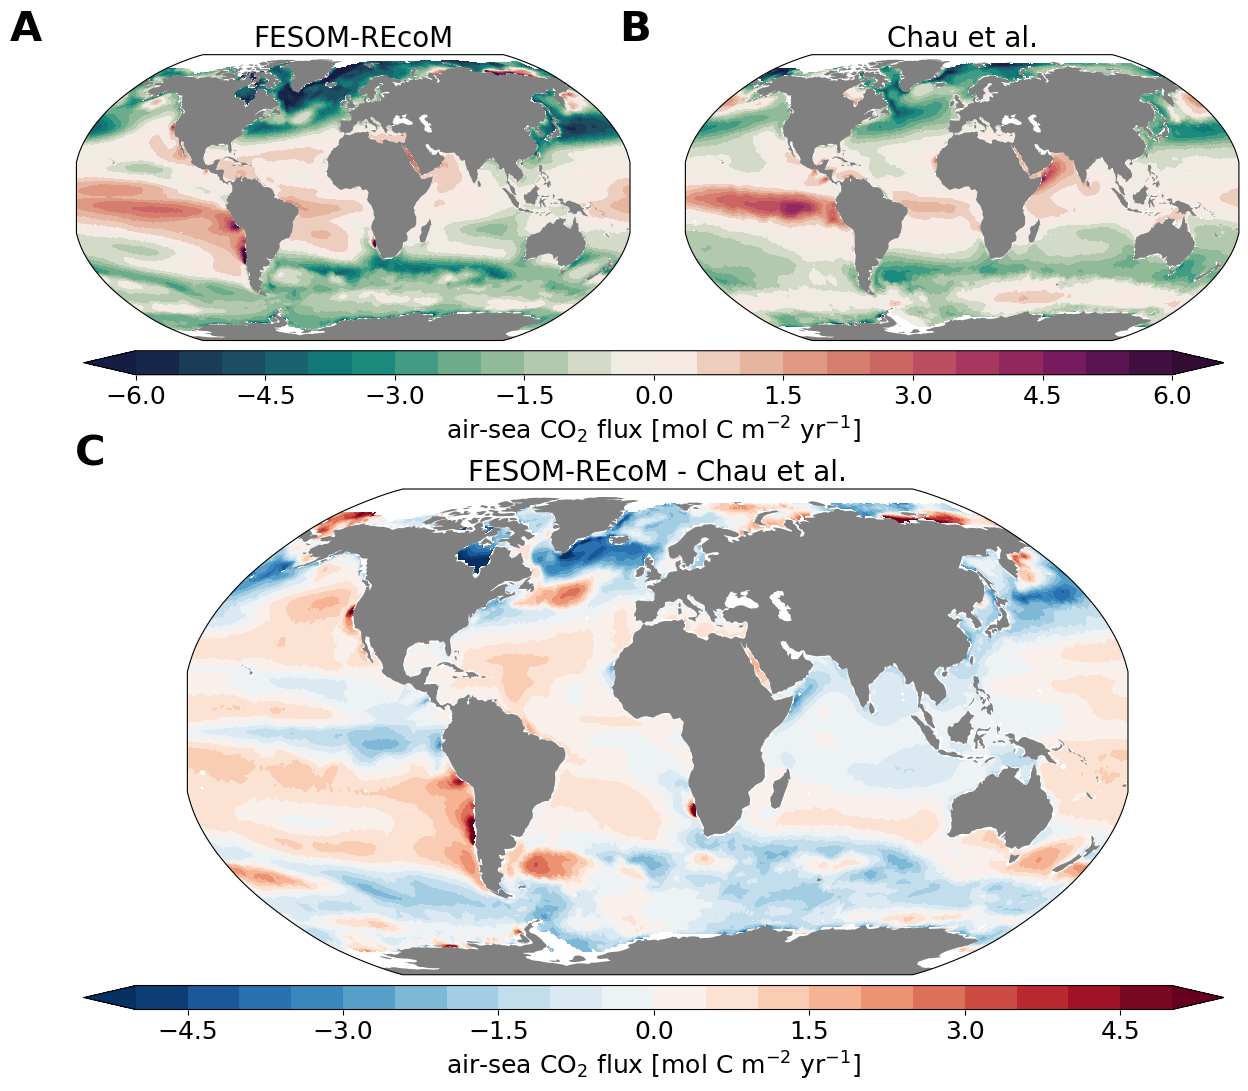


Original Taylor stats:
SDEV pred: 2.09975, ref: 1.64622
CRMS pred: 1.45886, ref: 0.00000
CORRCOEF: 0.72190

Normalized Taylor stats:
SDEV pred: 1.27550, ref: 1.00000
CRMS pred: 0.88619, ref: 0.00000
CORRCOEF: 0.72190
Adjust axis max to 1.5


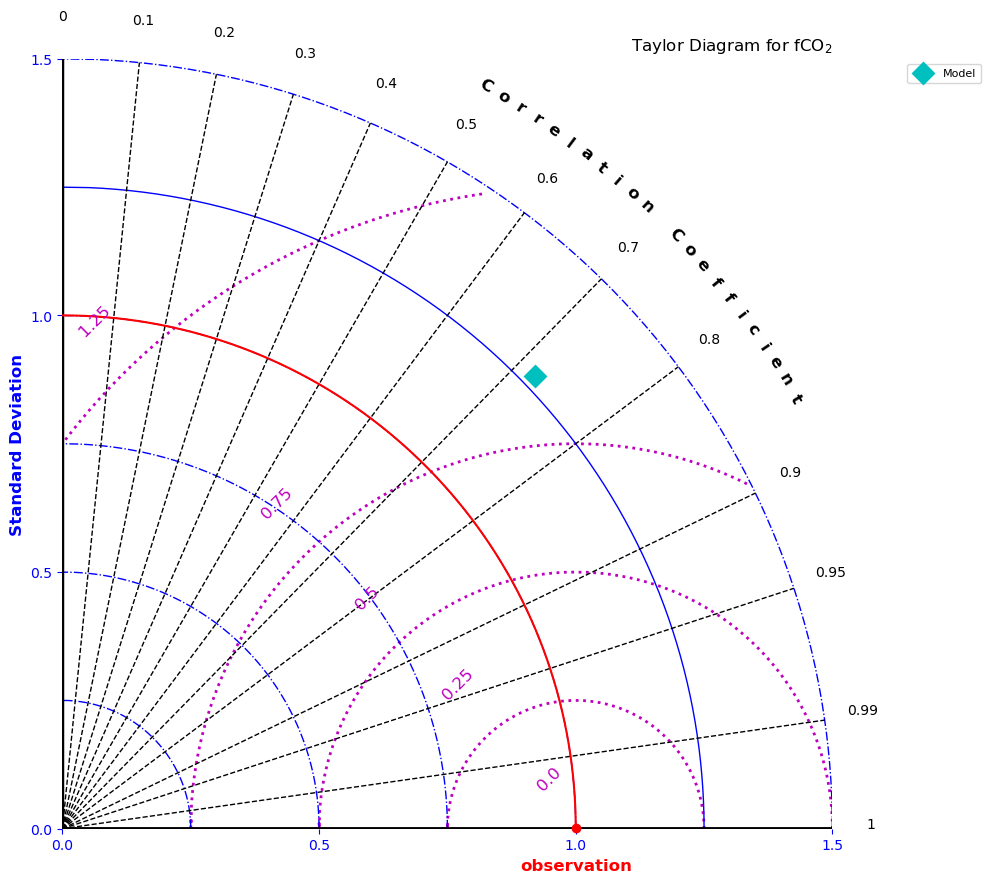

In [7]:
!jupyter nbconvert --to=python pCO2_Chauetal.ipynb
!jupyter nbconvert --to=python load_interp_Chauetal.ipynb
from pCO2_Chauetal import pCO2ccomp

pCO2ccomp(resultpath,savepath,mesh,ncfileCO2f,2011,2019,
                mapproj=mapproj,
                savefig=savefig, cmap = cmo.cm.curl)

[NbConvertApp] Converting notebook CO2f_Takahashi.ipynb to python
[NbConvertApp] Writing 10908 bytes to CO2f_Takahashi.py


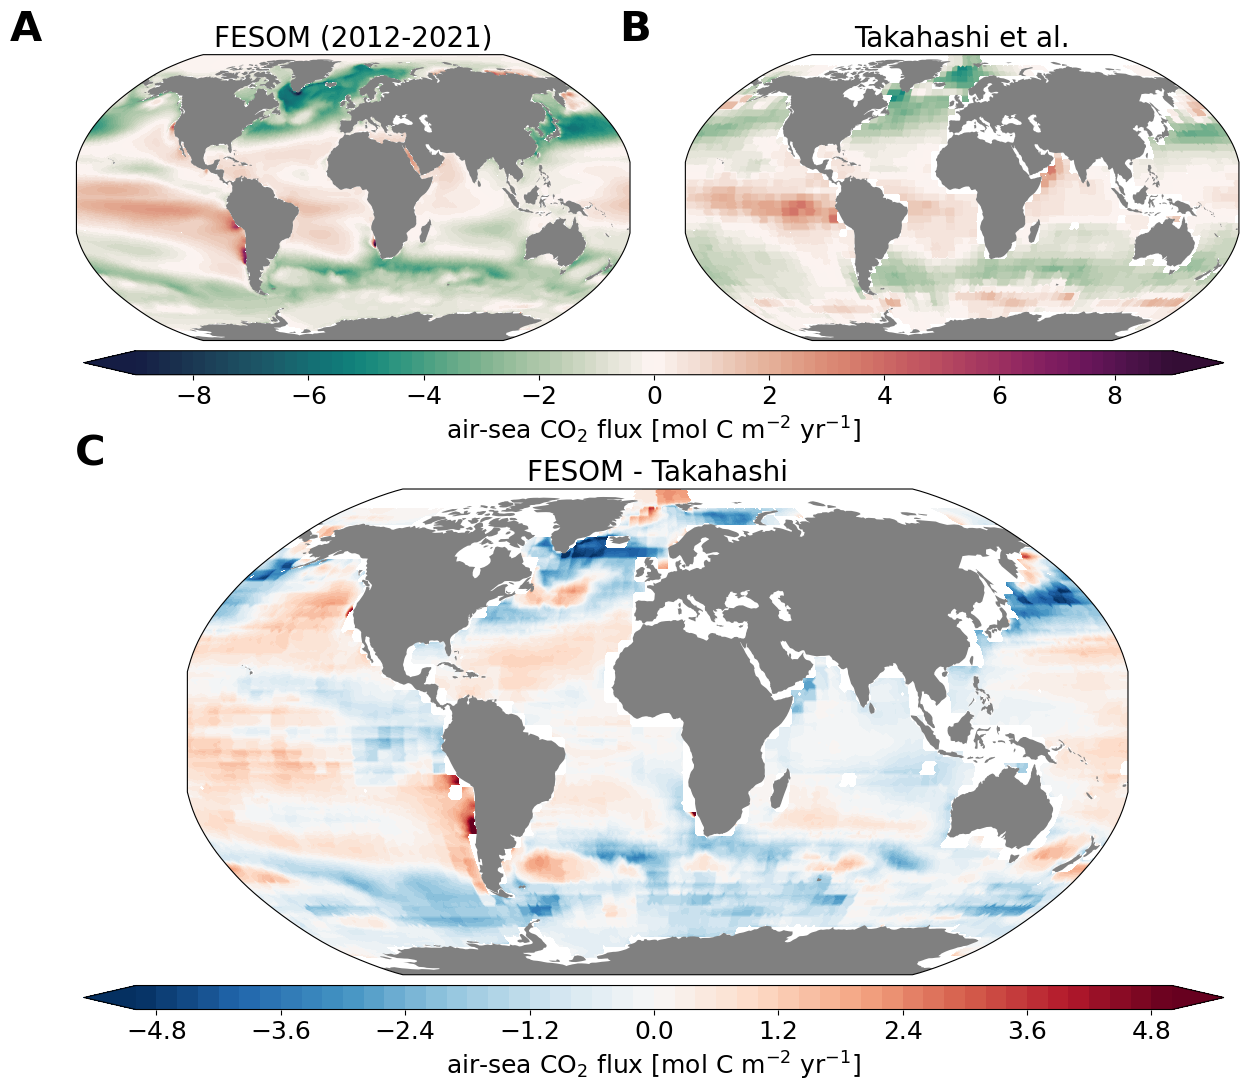


Original Taylor stats:
SDEV pred: 1.87014, ref: 1.37991
CRMS pred: 1.23523, ref: 0.00000
CORRCOEF: 0.75094

Normalized Taylor stats:
SDEV pred: 1.35526, ref: 1.00000
CRMS pred: 0.89515, ref: 0.00000
CORRCOEF: 0.75094
Adjust axis max to 1.5


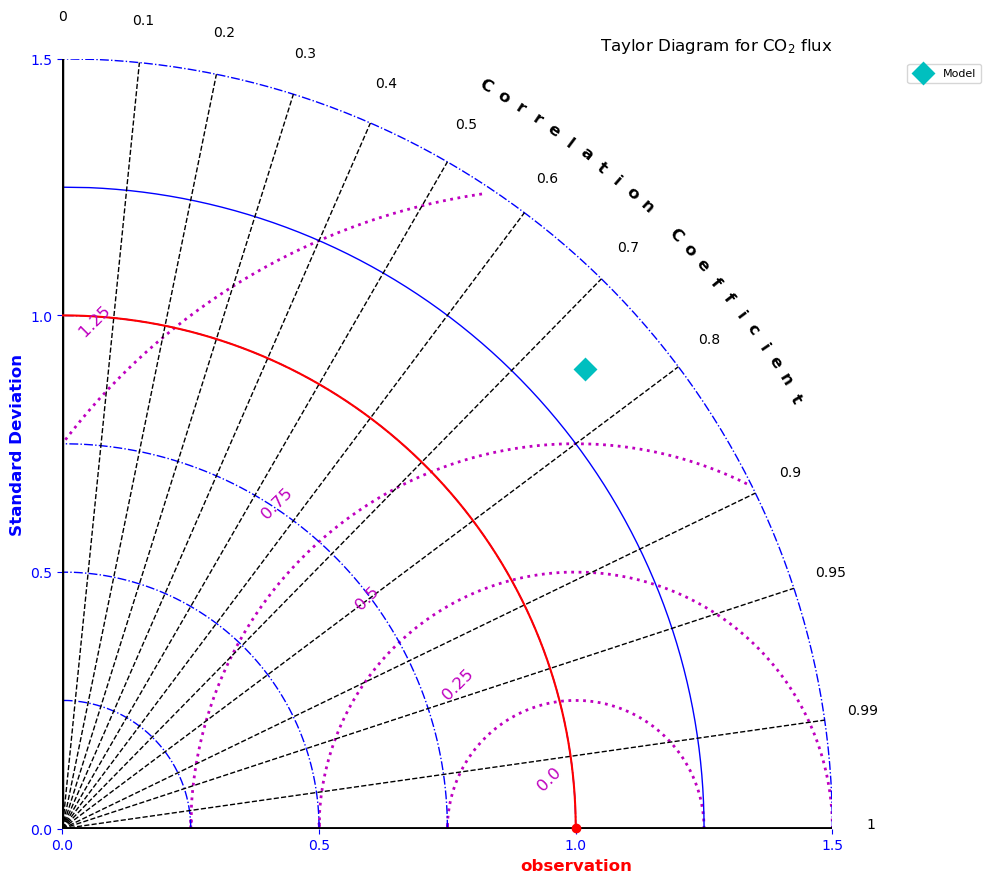

In [8]:
# there is a change of sign in the script, so that negative is CO2 uptake and positive is CO2 outgassing
!jupyter nbconvert --to=python CO2f_Takahashi.ipynb
from CO2f_Takahashi import CO2f_Takahashi_comp

CO2f_Takahashi_comp(resultpath,savepath,mesh,txtfileCO2flux,first_year_maps,last_year,
                           mapproj=mapproj,savefig=savefig, cmap = cmo.cm.curl)

## 3.2 Time series<a class="anchor" id="CARBSTS"></a>

[NbConvertApp] Converting notebook CO2f_timeseries.ipynb to python
[NbConvertApp] Writing 15999 bytes to CO2f_timeseries.py


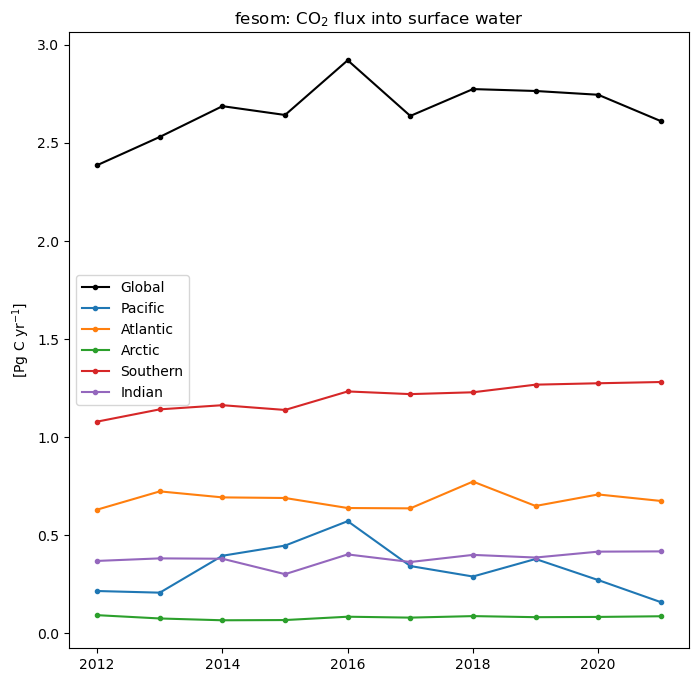

In [4]:
# positive is CO2 uptake, negative is outgassing
!jupyter nbconvert --to=python CO2f_timeseries.ipynb
from CO2f_timeseries import CO2f_timeseries

CO2f_timeseries(resultpath,savepath,mesh,first_year,last_year,savefig=savefig,regional='all')

## 3.3 Profiles<a class="anchor" id="CARBSPRO"></a>

[NbConvertApp] Converting notebook Carbs_profiles.ipynb to python
[NbConvertApp] Writing 14747 bytes to Carbs_profiles.py
[NbConvertApp] Converting notebook load_interp_GLODAP.ipynb to python
[NbConvertApp] Writing 7234 bytes to load_interp_GLODAP.py
***
Loading GLODAP file: /albedo/work/projects/p_pool_recom/eval/data/GLODAPv2.2016b.TCO2_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***
***
Loading GLODAP file: /albedo/work/projects/p_pool_recom/eval/data/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***


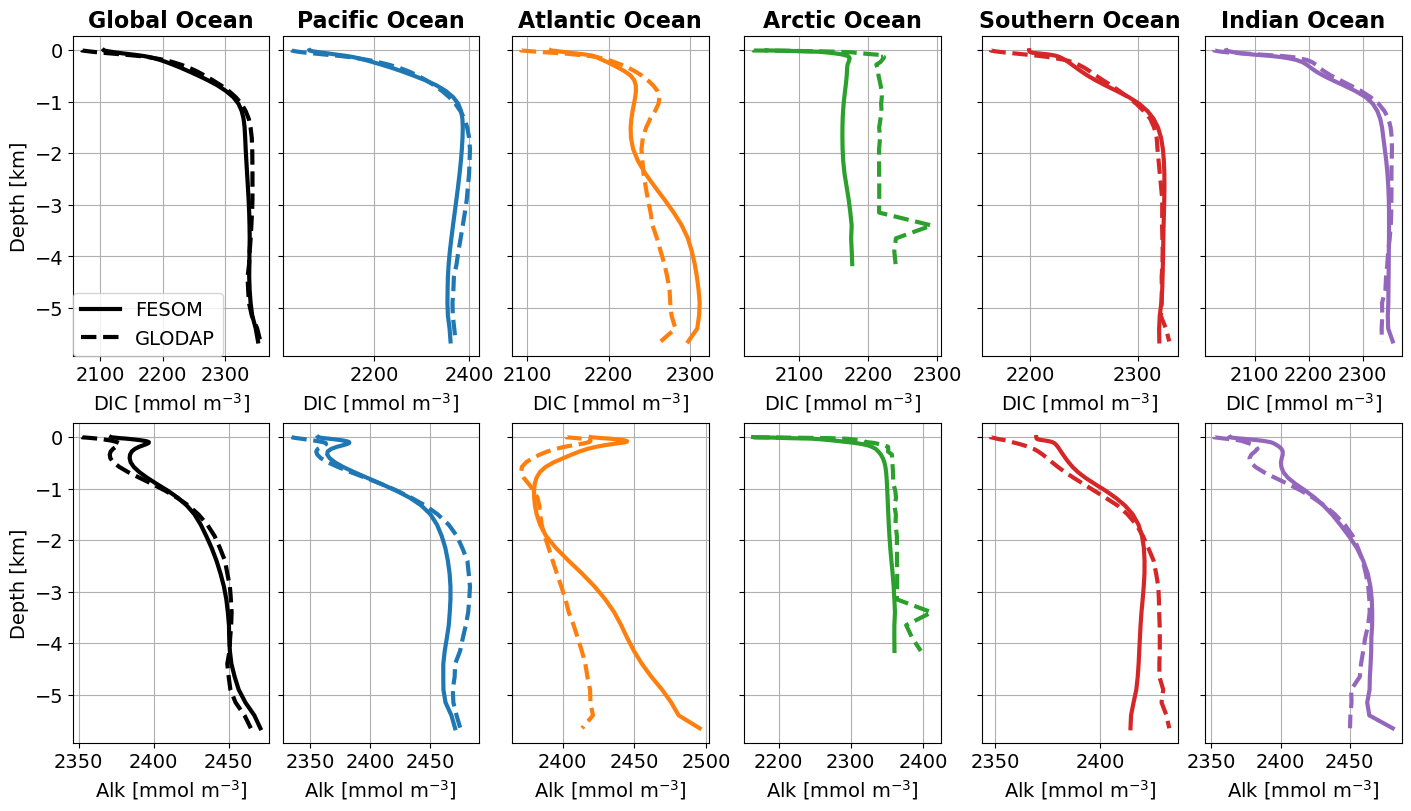

In [5]:
!jupyter nbconvert --to=python Carbs_profiles.ipynb
!jupyter nbconvert --to=python load_interp_GLODAP.ipynb
from Carbs_profiles import Carbs_profile

Carbs_profile(resultpath,savepath,mesh,ncfileAlk,ncfileDIC,first_year_maps,last_year,
                 savefig=savefig, regional=True)

# Save notebook as html

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
%autosave 2
!jupyter nbconvert $nb_name --output-dir=$htmlpath --to html --no-input